# Depolarization of opinions

Let us consider a system of $N$ agents, each agent $i$
characterized by a dynamic opinion variable $x_i(t)$. For
the sake of simplicity, we consider opinions to be one dimensional,
with $x_i \in [-\infty;+\infty]$. The sign of the opinion
$x_i$, $\sigma(x_i)$, describes the agent's qualitative stance towards
 a binary issue of choice, such as the preference
between two candidates or a pro/con attitude in a controversial
topic. The absolute value of $x_i$, $|x_i|$, describes
the opinion's strength, or conviction, with respect to one
of the sides: the larger $|x_i|$, the more extreme the opinion
of agent $i$.

## Imports and settings

If in a Colab notebook, this will
1. mount your Google Drive (by asking for an authorization code)
1. pull the latest version of ``opinion_dynamics`` from GitHub
1. add ``opinion_dynamics`` to path
1. install/upgrade packages
    - upgrade ``tqdm`` for ``tenumerate`` function
    - upgrade ``tables`` for appending to `hdf5` files without throwing an error.
    - ``vaex`` for large file reading without crashing the session
        - upgrade ``IPython`` for ``vaex`` [see #514](https://github.com/vaexio/vaex/issues/514)
1. make `.cache` and `.output` in your Google Drive under `My Drive > Colab Notebooks > opdynamics`
1. create symlinks between Colab's temporary local `.cache` and `.output` and the Google Drive folders for persistence

> Note:
> 1. After installing packages it **must** restart runtime.
> 1. Creating symlinks will fail when running the cell again. This is expected.

In [1]:
#@title Colab Setup { display-mode: "form" }
from opdynamics.visualise.dense import plot_surfaces
try:
    # connect GDrive for retrieving/saving results
    from google.colab import drive
    drive.mount('/content/drive')

    # Clone github repository
    from os.path import join  
    GIT_USERNAME = "chriscurrin"
    # TODO: remove this from github before publishing
    GIT_TOKEN = "bbf24b4521d81a3893d6c93eb806d41b47322a33"  
    GIT_REPOSITORY = "opinion_dynamics" 
    GIT_PATH = "https://" + GIT_TOKEN + "@github.com/" + GIT_USERNAME + "/" + GIT_REPOSITORY + ".git"
    !rm -rf ./temp
    !git clone --quiet "{GIT_PATH}" ./temp

    # add to path
    import sys
    sys.path.append('./temp')
    # need latest tqdm version for tenumerate and tables to prevent HDF read error
    !pip install -q --upgrade tqdm tables
    !pip install -q --upgrade vaex IPython
    # create symlink between a Drive folder and the cache for persistence between sessions
    import os
    try:
        os.makedirs("/content/drive/My Drive/Colab Notebooks/opdynamics/.cache")
        os.makedirs("/content/drive/My Drive/Colab Notebooks/opdynamics/output")
    except IOError:
        pass
    !ln -s "/content/drive/My Drive/Colab Notebooks/opdynamics/.cache" ".cache"
    !ln -s "/content/drive/My Drive/Colab Notebooks/opdynamics/output" "output"
except ModuleNotFoundError:
    print("local notebook")
    pass

local notebook


In [2]:
#@title Imports and settings { display-mode: "form" }
%reload_ext autoreload
%autoreload 2

import logging
import itertools
import os
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from tqdm.notebook import tqdm
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm
from matplotlib.cbook import flatten



try:
    import opdynamics.simulation as Simulation
except AttributeError:
    raise RuntimeError("restart runtime")
from opdynamics.networks.echochamber import (EchoChamber, ConnChamber, ContrastChamber, OpenChamber, SampleChamber,
                                             logger as eclogger,
                                             )
from opdynamics.visualise import (VisEchoChamber,
                                  show_K_alpha_phase,
                                  show_activity_vs_opinion,
                                  show_jointplot,
                                  show_noise_panel,
                                  show_opinion_grid,
                                  )
from opdynamics.utils.distributions import negpowerlaw
from opdynamics.utils.plot_utils import df_multi_mask, move_cbar_label_to_title
from opdynamics.utils.constants import *

try:
    os.makedirs("output")
except FileExistsError:
    pass
try:
    os.makedirs(".cache")
except FileExistsError:
    pass

np.random.seed(1337)
sns.set(context="notebook", style="ticks",
        rc={
            "figure.facecolor":"white",
            "axes.spines.left": True,
            "axes.spines.bottom": True,
            "axes.spines.right": False,
            "axes.spines.top": False,
            }
        )
logging.basicConfig(level=logging.DEBUG)
logging.getLogger().setLevel(logging.DEBUG)
eclogger.setLevel(logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.INFO)

# EchoChamber

We start by showing the rich *object orientated programming* (OOP) approach to building and running a network that produces echo chambers.

Later, we show how to use `simulation`, which encapsulates a lot of the OOP concepts into a more *functional* approach.

## Define parameters

 Symbol     | Variable | Keyword      | Meaning                                   | Range ($\mathbb{R}$)
------------|----------|--------------|-------------------------------------------|---------------------
 N          | N        | ``N``        | Number of agents                          | $>=1$
 m          | m        | ``m``        | Number of other agents to interact with   | $[1,N)$
 $\alpha$   | α        | ``alpha``    | controversialness of issue                | $>0$
 $K$        | K        | ``K``        | social interaction strength               | $>0$
 $\epsilon$ | ε        | ``epsilon``  | minimum activity level with another agent | $>0$
 $\gamma$   | Υ        | ``gamma``    | power law decay of activity distribution  | $[-\infty, \infty]$
 $\beta$    | β        | ``beta``     | power law decay of connection probability | $[-\infty, \infty]$
 $r$        | r        | ``r``        | probability of a mutual interaction       | $[0,1]$ 
 

In [3]:
N = 1000
m = 10
alpha = 3
K = 3
epsilon = 1e-2
gamma = 2.1
beta = 3
r = 0.5
activity_distribution = negpowerlaw

## Create EchoChamber object

An associated `VisEchoChamber` object is created for quick visualisations.

In [4]:
ec = EchoChamber(N, m, K, alpha)
vis = VisEchoChamber(ec)

## Set activity based on powerlaw distribution

$$ F(a) = \frac{1 - γ}{1 - ε^{1 - γ}} a^{-\gamma} \tag{1}$$

(<Figure size 576x360 with 3 Axes>,
 <matplotlib.colorbar.Colorbar at 0x2394876cec8>)

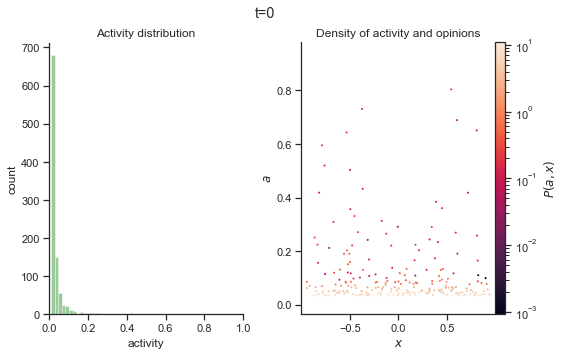

In [5]:
ec.set_activities(activity_distribution, gamma, epsilon)
fig, ax = plt.subplots(1,2, figsize=(8,5))
fig.subplots_adjust(wspace=0.3)
fig.suptitle("t=0")
vis.show_activities(ax=ax[0])
vis.show_activity_vs_opinion(ax=ax[1])

## Connection probabilities

$$ p_{ij} = \frac{|x_i - x_j|^{-\beta}}{\sum_j |x_i - x_j|^{-\beta}} \tag{2}$$

By default, the probabilities are set once and used throughout the simulation.

DEBUG:plot utils:move_cbar_label_to_title: guessing last axes in the fig is the cbar_ax


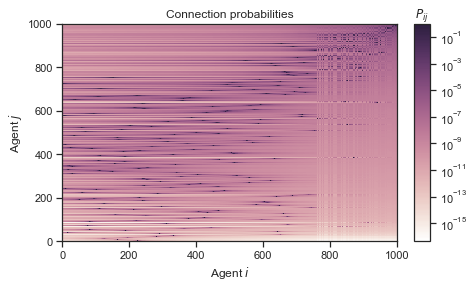

In [6]:
ec.set_connection_probabilities(beta=beta)
fig, ax = vis.show_connection_probabilities("mesh", sort=True, 
                                  cmap=sns.cubehelix_palette(light=1, as_cmap=True), 
                                  cbar_kws=dict(pad=0.05))
# move label to title
move_cbar_label_to_title(fig)

## Social Interactions

Adjacency matrix $A_{ij}(t)$ is computed at every time $t$.

Values of $1$ in $A_{ij}(t)$ indicate that agent $i$ is interacted with by agent $j$. $0$ means no interaction.

Every interaction from $j$ to $i$ has a chance $r$ of being reciprocal/mutual. That is, $r=0$ means a directed graph of
interactions, one-way influence, and $r=1$ means an undirected graph of connections and a symmetrical adjacency matrix.

- The matrices are computed either
    - before the network is run (`run_network`) using `lazy=False` (*warning: can use a lot of RAM!*)
    - on demand using `lazy=True`.
- Cumulative adjacency matrix $\sum_{t=0}^T A_{ij}(t)$ can be plotted a number of ways using `vis.show_adjacency_matrix(...)`
    - `clustermap`
    - `heatmap`
    - `mesh`
    
    Interactions can be sorted using `sort=True` for plotting to identify clusters

DEBUG:social interaction:Social Interaction for echochamber initialised with r=0.5.
INFO:social interaction:eagerly computing 501 adjacency matrices...
501it [00:14, 33.44it/s]
DEBUG:social interaction:adjacency matrix has shape = (501, 1000, 1000)


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x239492b2d08>)

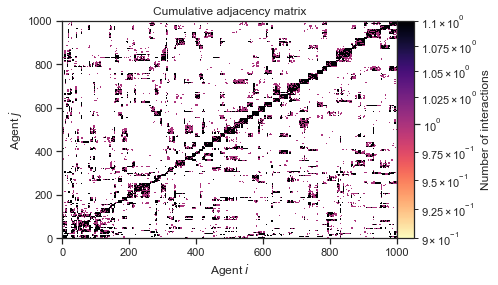

In [7]:
ec.set_social_interactions(0.5, lazy=False, t_end=5, dt=0.01)
vis.show_adjacency_matrix("mesh", True)

## Dynamics


Assuming that the opinion dynamics is solely
driven by the interactions among agents, we formulate
the model as $N$ coupled ordinary differential equations,

$$ \dot{x_i} = -x_i + K \sum_{j=1}^{N} A_{ij}(t) \tanh(\alpha x_j) \tag{3}$$

where K > 0 denotes the social interaction strength
among agents and $\alpha$ determines the sigmoidal shape of
the hyperbolic tangent. The opinion of an agent $i$ follows
the aggregated social input from the set of his/her neighbors
at time $t$, determined by the symmetric adjacency
matrix of the temporal network $A_{ij}(t)$, where $A_{ij}(t) = 1$
if agents $i$ and $j$ are interacting at time $t$, $A_{ij}(t) = 0$
otherwise. A similar model with static connectivity has
previously been used to describe the dynamics of neural
networks showing a transition from stationary to chaotic
phase [30].
The parameter $\alpha > 0$ tunes the degree of non-linearity
between an agent's opinion and the social influence they exert on others.

In [8]:
ec.set_dynamics()

## Run and plot results

In [9]:
dt = 0.01
T = 0.5
ec.run_network(dt=dt, t_end=T, method='Euler')

INFO:solvers:solving ODE using Euler
INFO:solvers:51 iterations to do...
INFO:echo chamber:done running echochamber


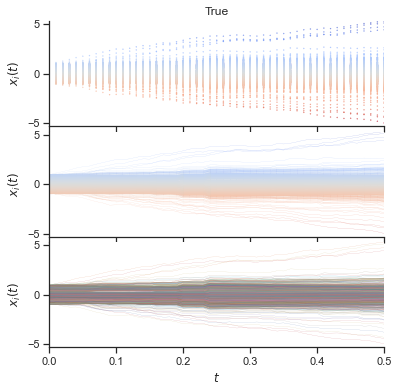

In [10]:
# some options on how to plot
fig, ax = plt.subplots(nrows=3, sharex='col', sharey='col', figsize=(6,6))
fig.subplots_adjust(hspace=0.05)
vis.show_opinions(color_code=True, ax=ax[0], title=True)     # markers
vis.show_opinions(color_code='line', ax=ax[1], title=False)  # lines
vis.show_opinions(color_code=False, ax=ax[2], title=False)   # agents uniquely coloured
sns.despine(fig)

## Save/Load

Given the same parameters, a network can be restored without explicitly calling `run_network`. 

A simulation is saved using `ec.save(only_last=True)`. If `only_last` is `False`, the entire duration of the simulation is saved.

If a simulation exists for the network parameters, `ec.load()` restores the saved states and returns `True` (returns `False` otherwise).

In [ ]:
filename = ec.save()
new_ec = EchoChamber(N, m, K, alpha)
new_ec.set_activities(activity_distribution, gamma, epsilon)
new_ec.set_connection_probabilities(beta=beta)
new_ec.set_social_interactions(0.5, lazy=True) # note only the `r` is the important parameter
new_ec.set_dynamics()
loaded = new_ec.load(dt, T)
if not loaded:
    print("run network")
    new_ec.run_network(dt, T)
else:
    print("results loaded")

# Example results

> The convenient `Simulation.run_params` static method is used.

In [11]:
# General params

N=1000
m=10
T=10
epsilon=1e-2
gamma=2.1
r=0.5 # probability of mutual interaction
dt=0.01

# Specific params for different dynamics
param_set={
    "neutral": dict(K=3,alpha=0.05,beta=2),
    "radical": dict(K=3,alpha=3,beta=0),
    "polar": dict(K=3,alpha=3,beta=3)
    }

## Neutral opinion

Low controversialness

- $K = 3$
- $\alpha = 0.05$
- $\beta = 2$

DEBUG:simulation:run_params for EchoChamber with (N=1000, m=10, K=3, alpha=0.05, beta=2, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=True, lazy=True)
DEBUG:simulation:additional args=()	additional kwargs={}
DEBUG:social interaction:Social Interaction for echochamber initialised with r=0.5.
DEBUG:echo chamber:trying to hit cache for C:\dev\opinion_dynamics\.cache\36837474927046260.h5
echochamber=EchoChamber(N=1000,m=10,K=3,alpha=0.05,seed=1337) negpowerlaw(2.1, 0.01, 1) p_conn(beta=2) adj_mat(r=0.5)
INFO:echo chamber:done running echochamber
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
C:\Users\Chris\Anaconda3\envs\opinion_dynamics\lib\site-packages\pandas\core\generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->values] [items->None]

  encoding=encoding,
DEBUG:echo chamber:save

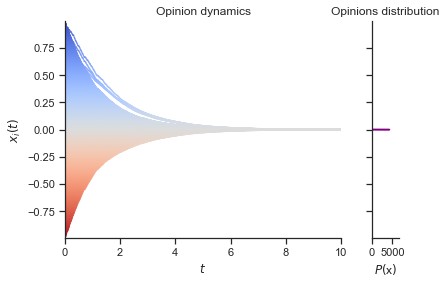

In [12]:
ec_neutral = Simulation.run_params(EchoChamber, N=N, m=m, **param_set['neutral'],
                                   activity=activity_distribution, epsilon=epsilon, gamma=gamma, r=r,
                                   dt=dt, T=T, plot_opinion=True,
                                   cache="all")

## Radicalisation of opinions

Uniform connection probabilities

- $K = 3$
- $\alpha = 3$
- $\beta = 0$

DEBUG:simulation:run_params for EchoChamber with (N=1000, m=10, K=3, alpha=3, beta=0, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=True, lazy=True)
DEBUG:simulation:additional args=()	additional kwargs={}
DEBUG:social interaction:Social Interaction for echochamber initialised with r=0.5.
DEBUG:echo chamber:trying to hit cache for C:\dev\opinion_dynamics\.cache\2116557791988040464.h5
echochamber=EchoChamber(N=1000,m=10,K=3,alpha=3,seed=1337) negpowerlaw(2.1, 0.01, 1) p_conn(beta=0) adj_mat(r=0.5)
INFO:echo chamber:done running echochamber
C:\Users\Chris\Anaconda3\envs\opinion_dynamics\lib\site-packages\pandas\core\generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->values] [items->None]

  encoding=encoding,
DEBUG:echo chamber:saved to C:\dev\opinion_dynamics\.cache\2116557791988040464.

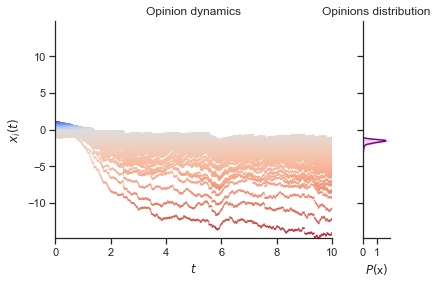

In [13]:
ec_radical = Simulation.run_params(EchoChamber, N=N, m=m, **param_set['radical'],
                                   activity=activity_distribution, epsilon=epsilon, gamma=gamma, r=r,
                                   dt=dt, T=T, plot_opinion=True,
                                   cache="all")

## Polarisation of opinions

Strong social interactions ($K$), controversial issue ($\alpha$), and greater chance of connecting with people with similar opinions ($\beta$)

- $K = 3$
- $\alpha = 3$
- $\beta = 3$

DEBUG:simulation:run_params for EchoChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=True, lazy=True)
DEBUG:simulation:additional args=()	additional kwargs={}
DEBUG:social interaction:Social Interaction for echochamber initialised with r=0.5.
DEBUG:echo chamber:trying to hit cache for C:\dev\opinion_dynamics\.cache\249548446193450509.h5
echochamber=EchoChamber(N=1000,m=10,K=3,alpha=3,seed=1337) negpowerlaw(2.1, 0.01, 1) p_conn(beta=3) adj_mat(r=0.5)
INFO:echo chamber:done running echochamber
C:\Users\Chris\Anaconda3\envs\opinion_dynamics\lib\site-packages\pandas\core\generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->values] [items->None]

  encoding=encoding,
DEBUG:echo chamber:saved to C:\dev\opinion_dynamics\.cache\249548446193450509.h5

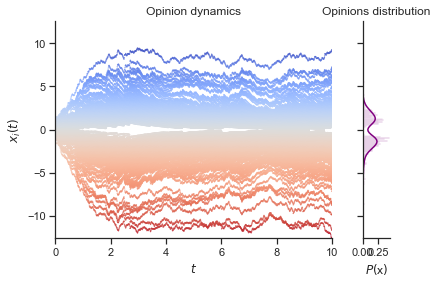

In [14]:
ec_polar = Simulation.run_params(EchoChamber, N=N, m=m, **param_set['polar'],
                                 activity=activity_distribution, epsilon=epsilon, gamma=gamma, r=r,
                                 dt=dt, T=T, plot_opinion=True,
                                 cache="all")

for moderate $\beta$, a polarised network may turn radical.

DEBUG:simulation:run_params for EchoChamber with (N=1000, m=10, K=3, alpha=3, beta=0.6, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=20, r=0.5, plot_opinion=False, lazy=True)
DEBUG:simulation:additional args=()	additional kwargs={}
DEBUG:social interaction:Social Interaction for echochamber initialised with r=0.5.
DEBUG:echo chamber:trying to hit cache for C:\dev\opinion_dynamics\.cache\1398987630720825824.h5
echochamber=EchoChamber(N=1000,m=10,K=3,alpha=3,seed=1337) negpowerlaw(2.1, 0.01, 1) p_conn(beta=0.6) adj_mat(r=0.5)
INFO:echo chamber:done running echochamber
C:\Users\Chris\Anaconda3\envs\opinion_dynamics\lib\site-packages\pandas\core\generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->values] [items->None]

  encoding=encoding,
DEBUG:echo chamber:saved to C:\dev\opinion_dynamics\.cache\139898763072082

(<Figure size 432x288 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x239f0e48288>)

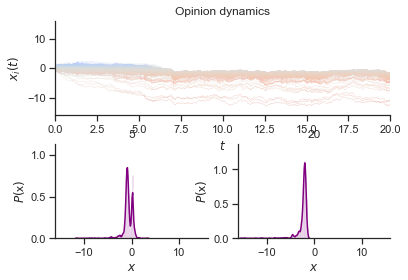

In [15]:
T=20
ec_polar_radical = Simulation.run_params(EchoChamber, N=N, m=m, 
                                         K=3, alpha=3, beta=0.6,
                                         activity=activity_distribution, epsilon=epsilon, gamma=gamma, r=r,
                                         dt=dt, T=T, plot_opinion=False,
                                         cache="all")
vis = VisEchoChamber(ec_polar_radical)
fig, axs = plt.subplots(2, 2, sharex='row', sharey=False)
gs = axs[0, 0].get_gridspec()
# remove the underlying axes
for ax in axs[0, :]:
    ax.remove()
axbig = fig.add_subplot(gs[0, :])
fig.subplots_adjust(hspace=0.3)
vis.show_opinions(color_code='line', subsample=2, lw=1, ax=axbig)
#vis.show_agent_opinions(t=5.0, direction=True, sort=True, ax=axs[1,0])
vis.show_opinions_snapshot(t=5.0, ax=axs[1,0], kde_kws=dict(bw=0.1, shade=True), title=f"5")
#vis.show_agent_opinions(direction=True, sort=True, ax=axs[1,-1])
vis.show_opinions_snapshot(ax=axs[1,-1], kde_kws=dict(shade=True), title=f"{T}")
#axs[1,0].set_xticklabels(ax[1,0].get_xticks())



## Compare opinions

(<Figure size 432x288 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2391710ff88>)

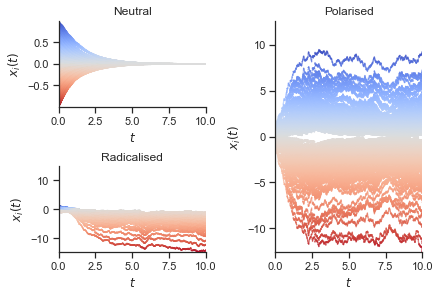

In [16]:
fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(nrows=2, ncols=2, figure=fig)
f_ax1 = fig.add_subplot(spec[0, 0]) # top left
f_ax2 = fig.add_subplot(spec[1, 0]) # bottom left
f_ax3 = fig.add_subplot(spec[:, 1]) # right column

VisEchoChamber(ec_neutral).show_opinions(ax=f_ax1, title="Neutral")
VisEchoChamber(ec_radical).show_opinions(ax=f_ax2, title="Radicalised")
VisEchoChamber(ec_polar).show_opinions(ax=f_ax3, title="Polarised")

# Central Limit Theorem

> Sample means are normally distributed.

> The mean of sample means approximates the true mean of the population.

In [ ]:
sample_size = 30 #@param {type:"slider", min:1, max:1000, step:1}
num_samples = 1000 #@param {type:"slider", min:1, max:1000, step:1}

fig, ax = plt.subplots()

sample_means = ec_polar.get_sample_means(sample_size, num_samples)
mu = np.mean(sample_means)

sns.distplot(sample_means)

ax.annotate(f"$\mu' = {mu:.4f}$", xy=(mu, ax.get_ylim()[1]), xytext=(0, 5), textcoords="offset points",
                  ha='left',va='bottom', fontsize='x-small',
                  arrowprops=dict(arrowstyle='-|>'))
true_mu = np.mean(ec_polar.opinions)
ax.annotate(f"$\mu = {true_mu:.4f}$", xy=(true_mu, ax.get_ylim()[1]), xytext=(0, 5), textcoords="offset points",
                  ha='left',va='top', fontsize='x-small',
                  arrowprops=dict(arrowstyle='-|>'))
ax.set_xlabel(f"$\overline{{X}}_n$\n[$n$ = {sample_size}]")
ax.set_ylabel(f"$P(\overline{{X}}_n)$\n[# samples = {num_samples}]")


# Plot types

## $K-\alpha$ phase space

- $K \in [0,4]$
- $\alpha \in [0,4]$

with
- $beta = 0.5$
- $r = 0.5$


In [ ]:
import os
import gc
eclogger.setLevel(logging.DEBUG)

beta = 0.5
r = 0.5


# how many simulations to run
num_states = 8
start = 0
stop = 4
K_range = np.round(np.linspace(start,stop,num_states), 2)
alpha_range = np.round(np.linspace(start,stop,num_states), 2)


# where to save the file
file_name = ".cache/K-alpha-phase.h5"

# the efficient HDF format is used for saving and loading DataFrames.
if os.path.exists(file_name):
    df = pd.read_hdf(file_name)
else:
    df = pd.DataFrame(index=K_range, columns=alpha_range, dtype=float)
    for K,alpha in tqdm(list(itertools.product(K_range,alpha_range))):
        ec = Simulation.run_params(EchoChamber,N=N, m=m, K=K, alpha=alpha, beta=beta, 
                                   activity=activity_distribution, epsilon=epsilon, gamma=gamma, r=r,
                                   dt=dt, T=T, 
                                   lazy=True, 
                                   cache=False, # don't cache full time of sim
                                   plot_opinion=False)
        t, mu = ec.get_mean_opinion(-1)
        df.loc[K, alpha] = mu
        # clear some memory
        del ec
        gc.collect()
    df.to_hdf(file_name, key='df')

In [ ]:
show_K_alpha_phase(df)
fig = plt.gcf()
fig.savefig("output/k-alpha-phase.pdf")

## Activity vs Opinion
Polarised param set
- $r = 0.65$

> to reproduce the density in the papers, $10^3$ "opinion states" need to be plotted, with each opinion state consisting of 1000 agents' opinions.

In [ ]:
# suppress logging for clean progressbar
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)

# parameters
N=1000
m=10
T=5
activity_distribution=negpowerlaw
epsilon=1e-2
gamma=2.1
dt=0.01
r=0.65

# how many simulations to run
try:
    from google.colab import drive
    num_states = 1000
except ModuleNotFoundError:
    num_states = 10
# where to save the file
file_name = ".cache/activity_vs_opinion.h5"

# helper array
agent_indices = np.arange(N, dtype=int)

# the efficient HDF format is used for saving and loading DataFrames.
with pd.HDFStore(file_name) as hdf:
    # get keys from the store to know how many simulations have already been saved
    states = hdf.keys()
    states_completed = len(states)
    # we start iterating from states_completed as the `seed` parameter uses `i`
    for i in tqdm(range(states_completed, num_states)):
        ec = Simulation.run_params(EchoChamber,N=N, m=m, **param_set['polar'],
                                   activity=activity_distribution, epsilon=epsilon, gamma=gamma, r=r,
                                   dt=dt, T=T, lazy=True, 
                                   cache=False, # don't cache time portion
                                   seed=i)
        # create dataframe for this iteration
        df = pd.DataFrame({"activity": ec.activities,
                           "opinion": ec.opinions
                          })
        # save to disk for use later
        hdf.append(f"d{i}", df)

# return to previous logging (more or less - we change root level)
logging.getLogger().setLevel(logging_level)


In [ ]:
# collect all data into a dataframe
with pd.HDFStore(file_name) as hdf:
    df_ao = pd.concat([hdf.get(key) for key in hdf.keys()])
df_ao.shape

In [ ]:
# plot everything
# (very good idea to rasterize for saving)
fig, ax, cbar = show_activity_vs_opinion(df_ao.opinion.values, df_ao.activity.values,
                                         bins=N, norm=LogNorm(vmin=1/N),
                                         cbar_kws=dict(cax=True),
                                         s=0.1, rasterized=True)
ax.set_ylim(0, 0.5)
sns.despine()
fig.savefig("output/activity_vs_opinion.pdf", dpi=500)

In [ ]:
# clear up some ram
del df_ao

## Show adjacency matrix

In [ ]:
vis = VisEchoChamber(ec_polar)
vis.show_adjacency_matrix("clustermap", ax=False, fig=False, sort=False)
fig, ax = plt.subplots(2, 1, figsize=(10,20))
vis.show_adjacency_matrix("heatmap", sort=True, square=True, ax=ax[0])
vis.show_adjacency_matrix("mesh", sort=True, ax=ax[1])


## Agent opinions at $t$

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,10), sharex=True)
fig.subplots_adjust(hspace=0.3)
vis.show_agent_opinions(direction=True, sort=True, ax=ax[0])
vis.show_opinions_snapshot(ax=ax[1], kde_kws=dict(shade=True))
ax[1].set_xticklabels(ax[1].get_xticks())
sns.despine()

In [ ]:
fig, ax = plt.subplots(1, 2, gridspec_kw=dict(width_ratios=[10,1]))
fig.subplots_adjust(wspace=0.1)
vis.show_opinions(ax=ax[0], title="Polarised")
vis.show_opinions_snapshot(ax=ax[1], kde_kws=dict(shade=False, bw=0.15), vertical=True)
sns.despine()
sns.despine(ax=ax[1], left=True)
ax[1].set_ylabel("")
ax[1].tick_params(axis='y', left=False, labelleft=False)

## Nearest Neighbour

In [ ]:
# Set up the subplot grid
f = plt.figure(figsize=(6, 6))
gs = plt.GridSpec(6, 6)

ax_joint = f.add_subplot(gs[1:, :-1])
ax_marg_x = f.add_subplot(gs[0, :-1], sharex=ax_joint)
ax_marg_y = f.add_subplot(gs[1:, -1], sharey=ax_joint)
# Make the grid look nice
sns.despine(f)
sns.despine(ax=ax_marg_x, left=True)
sns.despine(ax=ax_marg_y, bottom=True)
show_jointplot(ec_polar.opinions, ec_polar.get_nearest_neighbours(), ax=(ax_joint, ax_marg_x, ax_marg_y))
ax_joint.set_xlim(-5,5)
ax_joint.set_ylim(-5,5)

In [ ]:
levels=10
g = vis.show_nearest_neighbour(bw=0.5, color=sns.cubehelix_palette(levels, reverse=True)[levels//2],
                               cmap=sns.cubehelix_palette(levels, reverse=True, as_cmap=True), levels=levels,
                               shade_lowest=True)
# adjust limits based on xaxis
from scipy import stats
x_data, y_data = g.ax_marg_x.get_lines()[0].get_data()
s = stats.describe(y_data)
low_bound = np.max(s.mean-s.variance, 0)
mask = (low_bound < y_data)
lim = x_data[mask][0]*1.5, x_data[mask][-1]*1.5
g.ax_joint.set_xlim(*lim)
# keep it 'square' (xlim == ylim)
g.ax_joint.set_ylim(*lim)
g.savefig("output/nearest_neighbour.pdf")

# Summary

In [ ]:
# try "paper" "poster" "talk" or "notebook"
with sns.plotting_context("notebook"):
    fig, ax = vis.show_summary(fig_kwargs=dict(figsize=(12,12), constrained_layout=False))
fig.subplots_adjust(wspace=0.5, hspace=0.5)
sns.despine()

In [ ]:
from opdynamics.utils.plot_utils import move_cbar_label_to_title
with sns.plotting_context("paper"):
    # create figure and grid
    fig = plt.figure(figsize=(3.375, 2.618))
    gs = gridspec.GridSpec(nrows=2, ncols=2, wspace=1.1, hspace=0.9, height_ratios=[1,1.618])
    gs_trace_1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0,0],
                                                  width_ratios=[1, 0.15], 
                                                  wspace=0.1)
    gs_trace_2 = gridspec.GridSpecFromSubplotSpec(1, 2,  subplot_spec=gs[0,1],
                                                  width_ratios=[1, 0.15], 
                                                  wspace=0.1)
    gs_activity = gridspec.GridSpecFromSubplotSpec(1, 2,  subplot_spec=gs[1,0],
                                                  width_ratios=[1, 0.1], 
                                                  wspace=0.1)
    gs_nn = gridspec.GridSpecFromSubplotSpec(2, 2,  subplot_spec=gs[1,1],
                                             width_ratios=[1, 0.1], height_ratios=[0.1, 1], 
                                             wspace=0.1, hspace=0.1)
    # create axes
    ax_trace_1 = fig.add_subplot(gs_trace_1[0])
    ax_dist_1 = fig.add_subplot(gs_trace_1[1], sharey=ax_trace_1)
    ax_trace_2 = fig.add_subplot(gs_trace_2[0])
    ax_dist_2 = fig.add_subplot(gs_trace_2[1], sharey=ax_trace_2)
    ax_activity = fig.add_subplot(gs_activity[0])
    ax_activity_cax = fig.add_subplot(gs_activity[1])
    ax_joint = fig.add_subplot(gs_nn[1,0])
    ax_marg_x = fig.add_subplot(gs_nn[0,0], sharex=ax_joint)
    ax_marg_y = fig.add_subplot(gs_nn[1,1], sharey=ax_joint)

    # Make the grid look nice
    sns.despine(fig)
    sns.despine(ax=ax_dist_1, left=False, bottom=True)
    sns.despine(ax=ax_dist_2, left=False, bottom=True)
    ax_dist_1.tick_params(labelleft=False, bottom=False, labelbottom=False)
    ax_dist_2.tick_params(labelleft=False, bottom=False, labelbottom=False)
    sns.despine(ax=ax_marg_x, left=True)
    sns.despine(ax=ax_marg_y, bottom=True)
    
    # polarised opinions trace
    VisEchoChamber(ec_polar)
    vis.show_opinions(ax=ax_trace_1, color_code='line', subsample=10, lw=0.5, title="Polarised")
    vis.show_opinions_snapshot(ax=ax_dist_1, kde_kws=dict(shade=False, bw=0.15), vertical=True, title=False)

    # radicalised opinions trace
    vis_radical = VisEchoChamber(ec_radical)
    vis_radical.show_opinions(ax=ax_trace_2, color_code='line', subsample=2, lw=1, title="Radicalised")
    vis_radical.show_opinions_snapshot(ax=ax_dist_2, kde_kws=dict(shade=False, bw=0.15), vertical=True, title=False)

    # activity vs opinion
    file_name = ".cache/activity_vs_opinion.h5"
    with pd.HDFStore(file_name) as hdf:
        df_ao = pd.concat([hdf.get(key) for key in hdf.keys()])
    _,_,cbar = show_activity_vs_opinion(df_ao.opinion.values, df_ao.activity.values,
                                        ax=ax_activity,
                                        bins=N, norm=LogNorm(vmin=10/N),
                                        cbar_kws=dict(cax=ax_activity_cax),
                                        s=0.01, rasterized=True, title=False)
    cbar.outline.set_visible(False)
    del df_ao

    # nearest neighbour
    show_jointplot(ec_polar.opinions, ec_polar.get_nearest_neighbours(),
                   ax=(ax_joint, ax_marg_x, ax_marg_y))

    # cleaning
    ax_trace_1.set_ylim(-5, 5)
    ax_trace_2.set_ylim(-5, 5)
    ax_trace_1.set_xticks([0,5,10])
    ax_trace_2.set_xticks([0,5,10])
    ax_dist_1.set_ylabel("")
    ax_dist_2.set_ylabel("")
    ax_dist_1.set_xlabel("")
    ax_dist_2.set_xlabel("")
    ax_dist_1.set_xlim(0, 0.7)
    ax_dist_2.set_xlim(0, 1.4)
    ax_activity.set_ylim(0, 0.5)
    ax_activity.set_xlim(-10, 10)
    move_cbar_label_to_title(ax_activity_cax)

    ax_joint.set_xlim(-5, 5)
    ax_joint.set_ylim(-5, 5)
    ax_joint.set_xlabel(OPINION_SYMBOL)
    ax_joint.set_ylabel(MEAN_NEAREST_NEIGHBOUR)
    
    for letter, _ax in zip(string.ascii_lowercase, [ax_trace_1,ax_trace_2, ax_activity, ax_marg_x]):
        _ax.annotate(f"({letter})", xy=(0, 1), xycoords="axes fraction", 
                        xytext=(-27, 5), textcoords="offset points",
                        va="bottom", ha="right")
    # reduce space between axes labels and axes
    for _ax in flatten(fig.axes):
        _ax.yaxis.labelpad=0
        _ax.xaxis.labelpad=0
    fig.savefig("output/fig1.pdf")

# Noisy Echo Chamber

Add noise to the system

$\dot{x}_i= -x_i + K \sum^{N}_{j=1} A_{ij} (t)  \tanh(\alpha x_j)  + D [\rm nudge \ or \ noise]$


 Symbol      | Keyword      | Class (inherits from)            | Meaning                                                         | Range ($\mathbb{R}$)
-------------|--------------|----------------------------------|----------------------------------------------------------|---------------------
 $D$         | ``D``        |``NoisyEchoChamber(EchoChamber)`` | Strength of noise/nudge                                         | $>=0$
 $P(-\beta)$ | ``p_opp``    |``ConnChamber(EchoChamber)``      | Probability of interacting with an agent of opposing opinion    | $[0,1]$


### Open system (external noise)

$\dot{x}_i = K \cdot \sum_{j=1} A_{ij}(t) \cdot \tanh{(\alpha \cdot x_j)} + D \cdot \xi (t)$

 Symbol        | Variable | Keyword      | Class (inherits from)             | Meaning
---------------|----------|--------------|-----------------------------------|---------------
 $\xi(t)$      | -        | -            | ``OpenChamber(NoisyEchoChamber)`` | [Wiener process](https://en.wikipedia.org/wiki/Wiener_process)
 $\dot{\xi}$   | -        | -            | ``OpenChamber(NoisyEchoChamber)`` | Derivative $\mathcal{N}(0,\sqrt{dt})$


In [ ]:
# suppress logging for clean progressbar
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)
kwargs = dict(N=1000,
              m=10,
              T=5,
              epsilon=1e-2,
              gamma=2.1,
              dt=0.01,
              K=2,
              beta=1,
              alpha=3,
              r=0.65,
              cls=OpenChamber
             )
D_range = [0, 0.01, 0.1, 0.5, 1, 10]
nec_arr = Simulation.run_product({'D':{'range':D_range}}, plot_opinion=True, **kwargs)
fig = plt.gcf()
fig.subplots_adjust(hspace=-0.5)
for ax in fig.axes:
    ax.set_facecolor("None")
    sns.despine(ax=ax, bottom=True, left=True)
    ax.tick_params(bottom=False, left=False, labelleft=False)
fig.savefig("output/noise.pdf")
logging.getLogger().setLevel(logging_level)

## Check `dt` with noise

In [ ]:
# suppress logging for clean progressbar
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)
kwargs = dict(N=1000,
              m=10,
              T=1,
              epsilon=1e-2,
              gamma=2.1,
              dt=0.001,
              K=2,
              beta=1,
              alpha=3,
              r=0.65,
              cls=OpenChamber
             )
product_vars = {
    'D': {
        'range': [0, 0.01, 0.1, 1, 10],
    },
    'dt': {
        'range': np.arange(0.001, 0.01+0.001, 0.001)
        }
    }
Simulation.run_product(product_vars,
                       plot_opinion=True, title="dt",
                       label_precision=3, **kwargs)
fig = plt.gcf()
fig.savefig("output/dt.pdf")
logging.getLogger().setLevel(logging_level)

## Params vs noise

In [ ]:
kwargs = dict(N=1000,
              m=10,
              T=10,
              epsilon=1e-2,
              gamma=2.1,
              dt=0.01,
              K=2,
              beta=1,
              alpha=3,
              r=0.65,
              cls=OpenChamber
             )

D_range = np.round(np.arange(0.0, 1.1, 0.1), 1)

parameters = {
    'D': {
        'range': D_range,
    },
    'beta':  {
        'range': [0, 1, 2, 3],
        'title': "$\\beta$",
    },
    'alpha': {
        'range': [0.001, 1, 2, 3], 
        'title': "$\\alpha$",
    },
}
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)

df = Simulation.run_product(parameters, **kwargs)

logging.getLogger().setLevel(logging_level)

In [ ]:
with sns.plotting_context("talk"):
    max_range = max([other['range'] for other in parameters.values()], key=len)
    fig, ax = plt.subplots(len(parameters),len(max_range), sharey=True, sharex=True, squeeze=False)
    fig.subplots_adjust(hspace=0.8)
    for i, (key, other) in enumerate(parameters.items()):
        show_noise_panel(df, key,
                         bw=0.1, cut=2,
                         ax=ax[i])
        for _ax in ax[i]:
            _ax.set_title(f"{other['title']}={_ax.get_title()}")
            _ax.set_xlabel("")
            _ax.set(xlim=(-5,5), ylim=(0, 1))

    sns.despine(fig=fig)
    for _ax in ax[-1]:
        _ax.set_xlabel(math_fix(f"${OPINION_SYMBOL}$"))
    fig.savefig(f"output/{list(parameters.keys())}_grid.pdf")


## Delayed noise

In [ ]:
# suppress logging for clean progressbar
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)
kwargs = dict(N=1000,
              m=10,
              activity_distribution = negpowerlaw,
              epsilon=1e-2,
              gamma=2.1,
              dt=0.01,
              K=3,
              beta=3,
              alpha=3,
              r=0.65,
              cls=OpenChamber
             )
D=0.5

noise_start = 10.
noise_length = 10.
recovery = 10.
num = 1
interval = 0
nec = Simulation.run_periodic_noise(noise_start, noise_length, recovery, interval=interval, num=num, 
                                    **kwargs,
                                    D=D, plot_opinion=True)
fig = plt.gcf()
fig.savefig("output/delayed_noise.pdf")
logging.getLogger().setLevel(logging_level)


# Internal noise

## Contrastive noise

Noise comes from exposing each agent to a random other agent, $x_k$, independent of $\beta$.

Either
1. Contrast own opinion with another
    $\dot{x}_i = K \sum^{N}_{j=1} A_{ij} (t)  \tanh(\alpha_1 x_j)  + D (\tanh(\alpha_2 (x_i - x_k)))$
1. Show another agent's opinion
    $\dot{x}_i = K \sum^{N}_{j=1} A_{ij} (t)  \tanh(\alpha_1 x_j)  + D (\tanh(\alpha_2 (x_k)))$


 Symbol        | Keyword      | Class (inherits from)                  | Meaning
---------------|--------------|----------------------------------------|---------------
 $x_k$         | ``k_steps``  | ``ConstrastChamber(NoisyEchoChamber)`` | Another agent chosen every $k$ time steps.
 $\alpha_2$    | ``alpha_2``  | ``ConstrastChamber(NoisyEchoChamber)`` | Scaling of agent's opinion (or difference of opinions)



## Params vs noise

In [ ]:
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)
kwargs = dict(N=1000,
              m=10,
              T=10,
              epsilon=1e-2,
              gamma=2.1,
              dt=0.01,
              K=2,
              beta=1,
              alpha=3,
              r=0.65,
              k_steps=10,
              cls=ContrastChamber
             )

D_range = np.round(np.arange(0.0, 0.5, 0.05), 3)

parameters = {
    'D':{
        'range': D_range,
        'title': 'D',
    },
    'k_steps':{
        'range':[1, 100],
        'title':'k',
    },
    'alpha_2':{
        'range':[0.01, 0.1, 1, 10],
        'title':'$\alpha_2$',
    },
}
# suppress logging for clean progressbar
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)
noise_start = 0
            
df = Simulation.run_product(parameters,
                            noise_start=noise_start,
                            **kwargs)
logging.getLogger().setLevel(logging_level)

In [ ]:
grid_kwargs = dict(sharex=False, sharey=False, margin_titles=True, legend_out=True)
kde_kwargs = dict(bw=0.01)
g = show_opinion_grid(df, ['alpha_2','D','k_steps'], grid_kwargs=grid_kwargs, kde_kwargs=kde_kwargs)
g.add_legend(fontsize='large')

In [ ]:
g = show_opinion_grid(df, [x for x in parameters.keys() if x != "D"],
                    grid_kwargs=grid_kwargs, kde_kwargs=kde_kwargs)
g.map(sns.scatterplot, "opinion", "D", color='k', alpha=0.5, ec='None', s=1)

# Dynamic connections

 Symbol      | Keyword      | Class (inherits from)            | Meaning                                                         | Range ($\mathbb{R}$)
-------------|--------------|----------------------------------|----------------------------------------------------------|---------------------
 $P(-\beta)$ | ``p_opp``    |``ConnChamber(EchoChamber)``      | Probability of interacting with an agent of opposing opinion    | $[0,1]$


In [ ]:
#@title Dynamic connections { run: "auto", vertical-output: true }

# polar opinions
N = 1000
m = 10  # number of other agents to interact with
alpha = 3  # controversialness of issue (sigmoidal shape)
K = 3  # social interaction strength
epsilon = 1e-2  # minimum activity level with another agent
gamma = 2.1  # power law distribution param
beta = 3  # power law decay of connection probability
r = 0.5 # probability of a mutual interaction
activity_distribution = negpowerlaw
dt = 0.01
T = 10

p_opp = 0. #@param {type:"slider", min:0, max:1, step:0.05}

cc = ConnChamber(N, m, K, alpha)
cc.set_activities(activity_distribution, gamma, epsilon)
cc.set_connection_probabilities(beta=beta, p_opp=p_opp)
cc.set_social_interactions(r, lazy=True) # note only the `r` is the important parameter
cc.set_dynamics()
cc.run_network(dt, T, method='Euler')

vis = VisEchoChamber(cc)
fig, ax = plt.subplots(2, 2, gridspec_kw=dict(width_ratios=[1,0.1]))
vis.show_opinions(ax=ax[0,0])
fig.subplots_adjust(wspace=0.1, hspace=0.5)
vis.show_opinions_snapshot(ax=ax[0,1], vertical=True, kde_kws=dict(bw=0.1))
vis.show_adjacency_matrix("mesh", sort=True,
                                  cmap=sns.cubehelix_palette(light=1, as_cmap=True),
                                  cbar_kws=dict(pad=0.05, cax=ax[1,1]),
                                  ax=ax[1,0]
                                  )
move_cbar_label_to_title(ax[1,1])
for _ax in ax[0,:]:
    _ax.set_ylim(-5,5)
sns.despine()
sns.despine(ax=ax[0,1], left=True)
ax[0,1].set_ylabel("")
ax[0,1].set_yticks([])
fig.suptitle(f"p_opp={p_opp}")
fig.set_facecolor('w')


# Central Limit Theorem

Add a "population opinion" term that captures the Lindeberg–Lévy Central Limit Theorem.


$\dot{x}_i = K \sum^{N}_{j=1} A_{ij} (t)  \tanh(\alpha_1 x_j)  + D \cdot \sqrt {n}\left({\bar{X}}_{n}-\mu \right)$

where $X$ is a random sample and $\bar{X}_{n}$ is the sample mean for $n$ random samples.

According to CLT, the means of random samples are normally distributed.

By substracting the true (or accurate estimate of the ) mean, $\mu$, and scaling by sample size ($\sqrt{n}$),
the normal distribution is centered on $0$.

$\sqrt {n}\left({\bar{X}}_{n}-\mu \right) \rightarrow \mathcal{N}\left(0,\sigma^{2}\right)$

 Symbol      | Keyword          | Class (inherits from)            | Meaning                                                         | Range ($\mathbb{R}$)
-------------|------------------|----------------------------------|----------------------------------------------------------|---------------------
 $n$         | ``sample_size``  |``SampleChamber(NoisyEchoChamber, ConnChamber)``      | Number of opinions to sample from all agents    | $[0,N]$


In [ ]:
#@title CLT playground { run: "auto", vertical-output: true }

logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)

# polar opinions
N = 1000 #@param {type:"integer"}
m = 10 #@param {type:"integer"}
α = 3 #@param {type:"slider", min:0, max:5, step:0.5}
K = 3 #@param {type:"slider", min:0, max:5, step:0.5}
log10ε = -2 #@param {type:"slider", min:-3, max:0, step:-1}
ε = 1**log10ε
Υ = 2.1 #@param {type:"slider", min:0, max:3, step:0.1}
β = 3 #@param {type:"slider", min:0, max:5, step:0.5}
r = 0.5 #@param {type:"slider", min:0, max:1, step:0.1}
activity_distribution = negpowerlaw
dt = 0.01
T = 10
# Nudge arguments
D = 3 #@param {type:"slider", min:0, max:20, step:0.5}
sample_size = 10 #@param {type:"slider", min:1, max:100, step:1}

iterations = 1 #@param {type:"slider", min:1, max:20, step:1}
auto_run = False #@param {type:"boolean"}

if auto_run:
    fig, ax = plt.subplots(1, 2, gridspec_kw=dict(width_ratios=[1,0.1]), sharey=True)
    fig.subplots_adjust(wspace=0.1, hspace=0.5)
    palette = sns.color_palette("husl", n_colors=iterations)
    for i in range(iterations):
        sc = SampleChamber(N, m, K, α)
        sc.set_activities(activity_distribution, Υ, ε)
        sc.set_connection_probabilities(β)
        sc.set_social_interactions(r)
        sc.set_dynamics(D, sample_size)
        sc.run_network(dt, T, method='Euler')

        vis = VisEchoChamber(sc)
        vis.show_opinions(color_code='line', ax=ax[0])
        vis.show_opinions_snapshot(ax=ax[1], vertical=True,
                                kde_kws=dict(bw=0.1), color=palette[i])

    ax[0].set_ylim(-5,5)

logging.getLogger().setLevel(logging_level)

### Run parameter sweep

In [ ]:
logging_level = logging.getLogger().getEffectiveLevel()
eclogger.setLevel(logging.INFO)
logging.getLogger().setLevel(logging.WARNING)

parameters = dict(
    N=1000,
    m=10,
    T=10.0,
    epsilon=1e-2,
    gamma=2.1,
    dt=0.01,
    K=3,
    beta=3,
    alpha=3,
    r=0.5,
    cls=SampleChamber,
    method="Euler",
)

D_range = np.round(np.arange(0.0, 5.0001, 0.1), 3)

sample_size_range = np.arange(1, 50.0001, 1, dtype=int)

range_variables = {
    "D": {"range": D_range, "title": "D"},
    "sample_size": {"range": sample_size_range, "title": "n"},
    "alpha": {"range": [1, 2, 3], "title": "α"},
    "beta": {"range": [0, 1, 2, 3], "title": "β"},
    "K": {"range": [1, 2, 3]},
}

df = Simulation.run_product(
    range_variables,
    noise_start=0,
    cache=True,
    cache_sim=True,
    parallel=True,
    **parameters
)
logging.getLogger().setLevel(logging_level)

### Plot

In [ ]:
plot_surfaces(df, "D", "sample_size", parameters, range_variables)
plt.gcf().savefig(os.path.join("output","d_sample_surface.pdf"))

#### plot specific values

In [ ]:
grid_kwargs = dict(sharex=True, sharey=False,
                   margin_titles=True, legend_out=True)
kde_kwargs = dict(bw=0.01)

# choose a subset of D and sample_size to import
D_range = D_range[::2]

sample_size_range = sample_size_range[::10]

range_variables = {
    "D": {"range": D_range, "title": "D"},
    "sample_size": {"range": sample_size_range, "title": "n"},
    "alpha": {"range": [1, 2, 3], "title": "α"},
    "beta": {"range": [0, 1, 2, 3], "title": "β"},
    "K": {"range": [1, 2, 3]},
}

sub_df = Simulation.run_product(
    range_variables,
    noise_start=0,
    cache=True,
    cache_sim=True,
    parallel=True,
    **parameters
)

defaults = {
    'D': 'col',
    'sample_size': 'row',
    'alpha': 3,
    'K': 3,
    'beta': 3,
}
import ipywidgets as widgets
pickers = {}
for key in range_variables:
  if key in sub_df.columns:
    unique = sub_df[key].unique()
    desc = range_variables[key]['title'] if 'title' in range_variables[key] else key
    pickers[key] = widgets.Dropdown(description=desc,
                                    options=list(unique)+['col', 'row', 'hue'], value=defaults[key])

def f(**kwargs):
    try:
        out.clear_output()
    except:
        pass
    columns = []
    for key, value in kwargs.items():
        if value in ['col', 'row', 'hue']:
            if value == 'col':
                columns.insert(0, key)
            elif value == 'row':
                columns.insert(1, key)
            else:
                columns.append(key)
            continue
    default_kwargs = {k: v for k, v in kwargs.items() if k not in columns}
    default_df = df_multi_mask(sub_df, default_kwargs)
    print("plotting")
    g = show_opinion_grid(default_df, columns,
                          grid_kwargs=grid_kwargs, kde_kwargs=kde_kwargs)
    g.add_legend()
out = widgets.interactive_output(f, pickers)
widgets.VBox([widgets.HBox(list(pickers.values())), out])

In [ ]:
g = show_opinion_grid(df, ['D','sample_size'], grid_kwargs=grid_kwargs, kde_kwargs=kde_kwargs)
g.add_legend(fontsize='large')

In [ ]:
g = sns.relplot(x="opinion", y="D", hue="sample_size", size="alpha", style="beta",
                kind='scatter', data=df)


In [ ]:
g = show_opinion_grid(df,
                      [x for x in parameters.keys() if x != "D"],
                      grid_kwargs=grid_kwargs, kde_kwargs=kde_kwargs)
g.map(sns.scatterplot, "opinion", "D", color='k', alpha=0.5, ec='None', s=1)

In [ ]:
#@title Check noise behaviour { run: "auto", vertical-output: true }

from opdynamics.utils.accuracy import precision_and_scale

sc = SampleChamber(N, m, K, alpha)

D_xi = 1 #@param {type:"slider", min:0.1, max:2, step:0.1}

nudge = 10 #@param {type:"slider", min:0.2, max:20, step:0.2}
alpha_2 = 0.1 #@param {type:"slider", min:0.1, max:10, step:0.1}

D_sample = 1 #@param {type:"slider", min:0.1, max:2, step:0.1}
sample_size = 20 #@param {type:"slider", min:1, max:100, step:1}


T = 1.01 #@param {type:"slider", min:0.01, max:10, step:0.05}
dt = 0.01
n_iter = T//dt
k_steps = 1 #@param {type:"slider", min:1, max:100, step:1}

N = 1000
xi = np.random.random(N)
xi2 = np.copy(xi)
xi3 = np.copy(xi)
xi4 = np.copy(xi)
_idx = None

xi_minus_xk = []
xis= []
xi2s = []
xi3s = []
xi4s = []
ys = []
y2s = []
y3s = []
y4s = []

precision, scale = precision_and_scale(k_steps)
def choose_k(t, dt, _k_steps):
  global _idx
  if (scale and np.round(t, scale) % _k_steps == 0) or (
        int(t / dt) % _k_steps == 0
    ):
    _idx = np.round(
            np.random.uniform(0, N - 1, size=N), 0
        ).astype(int)

def sample(t, xi, *args):
    D, n = args
    return D * np.sqrt(n) * (np.mean(sc.get_sample_means(n, opinions=xi)) - np.mean(xi))

for t in np.arange(0, T, dt):
    choose_k(t, dt, k_steps)
    xi_minus_xk.append(xi-xi[_idx])
    y = nudge*np.tanh(alpha_2 * (xi-xi[_idx]))*dt
    xi += y
    y2 = nudge*np.tanh(alpha_2 * xi[_idx])*dt
    xi2 += y2
    y3 = D_xi*np.random.normal(loc=0,scale=np.sqrt(dt), size=N)
    xi3 += y3
    y4 = sample(t, xi3, D_sample, sample_size)*dt
    xi4 += y4

    ys.append(y)
    y2s.append(y2)
    y3s.append(y3)
    y4s.append(y4)

fig, axs = plt.subplots(1, 3, sharey=True,
                        gridspec_kw=dict(width_ratios=[1,1,0.1]))
axs[0].scatter(xi_minus_xk, ys,     s=10, ec='None', c='k', alpha=0.5/n_iter)
axs[0].scatter(xi_minus_xk, y2s,    s=10, ec='None', c='c', alpha=0.5/n_iter)
axs[0].scatter(xi_minus_xk, y3s,    s=10, ec='None', c='c', alpha=0.5/n_iter)
axs[0].scatter(xi_minus_xk, y4s,    s=10, ec='None', c='c', alpha=0.5/n_iter)
axs[1].scatter([xi]*len(ys), ys,   s=10, ec='None', c='k', alpha=0.5/n_iter)
axs[1].scatter([xi2]*len(y2s), y2s, s=10, ec='None', c='c', alpha=0.5/n_iter)
axs[1].scatter([xi3]*len(y3s), y3s, s=10, ec='None', c='c', alpha=0.5/n_iter)
axs[1].scatter([xi4]*len(y4s), y4s, s=10, ec='None', c='c', alpha=0.5/n_iter)
sns.kdeplot(y, ax=axs[2], color='k', vertical=True, shade=True)
sns.kdeplot(y2, ax=axs[2], color='c', vertical=True, shade=True)

axs[0].set_ylabel(f"$\Delta x_i$\n(noise only)")
axs[0].set_xlabel(f"$x_i - x_k$")
axs[1].set_xlabel(f"$x_i$")
axs[2].set_xlabel(f"$P(y)$")

axs[2].legend(["$D \cdot \\tanh(alpha_2 \cdot (x_i-x_k))$","$D \cdot \\xi(t)$"],
              loc='upper right', bbox_to_anchor=(0,1),
              frameon=False)

fig.set_facecolor('w')
sns.despine()